<a href="https://colab.research.google.com/github/y001003/Bootcamp/blob/main/ai06_sc23x_%EB%B0%95%EC%98%81%EC%88%98_2%EC%B0%A8%EC%A0%9C%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

In [ ]:
# analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn.model_selection
from sklearn.model_selection import train_test_split

# pipeline
from sklearn.pipeline import make_pipeline

# encoding
from category_encoders import TargetEncoder, OrdinalEncoder

# Imputing
from sklearn.impute import SimpleImputer, KNNImputer

# model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 

# metrics
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve

# hyperparameter Tunning
from sklearn.model_selection import RandomizedSearchCV

# model Visualization
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

# Part 1: 데이터 전처리 (Data Preprocessing)

In [ ]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
#> EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    60000 non-null  int64  
 1   DBA Name         60000 non-null  object 
 2   AKA Name         59283 non-null  object 
 3   License #        59996 non-null  float64
 4   Facility Type    58573 non-null  object 
 5   Risk             59976 non-null  object 
 6   Address          60000 non-null  object 
 7   City             59955 non-null  object 
 8   State            59985 non-null  object 
 9   Zip              59987 non-null  float64
 10  Inspection Date  60000 non-null  object 
 11  Inspection Type  60000 non-null  object 
 12  Violations       44130 non-null  object 
 13  Latitude         59822 non-null  float64
 14  Longitude        59822 non-null  float64
 15  Location         59822 non-null  object 
 16  Inspection Fail  60000 non-null  int64  
dtypes: float64(4

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    20000 non-null  int64  
 1   DBA Name         20000 non-null  object 
 2   AKA Name         19765 non-null  object 
 3   License #        20000 non-null  float64
 4   Facility Type    19548 non-null  object 
 5   Risk             19998 non-null  object 
 6   Address          20000 non-null  object 
 7   City             19989 non-null  object 
 8   State            19997 non-null  object 
 9   Zip              19996 non-null  float64
 10  Inspection Date  20000 non-null  object 
 11  Inspection Type  20000 non-null  object 
 12  Violations       14664 non-null  object 
 13  Latitude         19940 non-null  float64
 14  Longitude        19940 non-null  float64
 15  Location         19940 non-null  object 
 16  Inspection Fail  20000 non-null  int64  
dtypes: float64(4

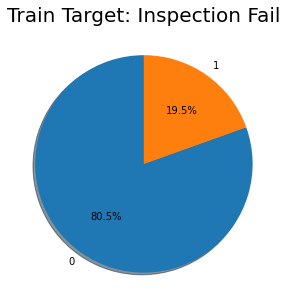

In [6]:
# target 확인 - train
import matplotlib.pyplot as plt

plt.subplots(figsize = (5,5))
plt.pie(train['Inspection Fail'].value_counts(), labels = train['Inspection Fail'].value_counts().index, 
        autopct="%.1f%%", shadow = True, startangle = 90)
plt.title('Train Target: Inspection Fail', size=20)
plt.show()

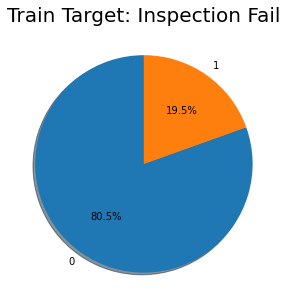

In [7]:
# target 확인 - train
import matplotlib.pyplot as plt

plt.subplots(figsize = (5,5))
plt.pie(train['Inspection Fail'].value_counts(), labels = train['Inspection Fail'].value_counts().index, 
        autopct="%.1f%%", shadow = True, startangle = 90)
plt.title('Train Target: Inspection Fail', size=20)
plt.show()

In [9]:
# 결측치 확인
train.isnull().sum(), test.isnull().sum()

(Inspection ID          0
 DBA Name               0
 AKA Name             717
 License #              4
 Facility Type       1427
 Risk                  24
 Address                0
 City                  45
 State                 15
 Zip                   13
 Inspection Date        0
 Inspection Type        0
 Violations         15870
 Latitude             178
 Longitude            178
 Location             178
 Inspection Fail        0
 dtype: int64, Inspection ID         0
 DBA Name              0
 AKA Name            235
 License #             0
 Facility Type       452
 Risk                  2
 Address               0
 City                 11
 State                 3
 Zip                   4
 Inspection Date       0
 Inspection Type       0
 Violations         5336
 Latitude             60
 Longitude            60
 Location             60
 Inspection Fail       0
 dtype: int64)

In [10]:
# 중복값 확인
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [11]:
# Cardinality 확인
train.describe(include="all").T.sort_values("unique", ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Violations,44130,44035,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBA Name,60000,20175,SUBWAY,830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKA Name,59283,19209,SUBWAY,1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Address,60000,15244,11601 W TOUHY AVE,755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,59822,14533,"(-87.91442843927047, 42.008536400868735)",760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Date,60000,2667,2013-11-14,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Facility Type,58573,366,Restaurant,39922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Type,60000,55,Canvass,31913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,59955,39,CHICAGO,59771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,59976,4,Risk 1 (High),42839,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

In [ ]:
def eda_process(df):

  # 복사
  df_temp = df.copy()

  # City 컬럼 처리 : City_chicago 칼럼을 만들어서 Chicago가 맞는 곳 1 과 아닌 곳 0 으로 구분
  Chicago_list = ["CHICAGO", "312CHICAGO", "CHCICAGO","CHICAGO.", "CHICAGOI", "CHICAGOCHICAGO", "CCHICAGO"]
  df_temp["City"] = df_temp["City"].str.upper()
  df_temp["City_Chicago"] = [1 if i in Chicago_list 
                             else 0 
                             for i in df_temp['City']]
  
  # Inspection date를 string에서 datetime으로 바꾼 후 연도, 월 추출
  df_temp["Inspection Date"] = train['Inspection Date'].apply(pd.to_datetime)
  df_temp["year"] = df_temp["Inspection Date"].dt.year
  df_temp["month"] = df_temp["Inspection Date"].dt.month  
  


  

In [17]:
train['City'] = train['City'].str.upper()

In [18]:
train['City'].unique()

array(['CHICAGO', 'CICERO', 'NILES NILES', 'MAYWOOD', 'INACTIVE', nan,
       'CHICAGOCHICAGO', 'EVANSTON', 'ELK GROVE VILLAGE', 'CHCICAGO',
       'OAK PARK', 'CCHICAGO', 'ROSEMONT', 'LAKE ZURICH',
       'EAST HAZEL CREST', 'BURNHAM', 'CHARLES A HAYES', '312CHICAGO',
       'SKOKIE', 'GRIFFITH', 'SCHAUMBURG', 'BOLINGBROOK', 'HIGHLAND PARK',
       'ELMHURST', 'PLAINFIELD', 'WHEATON', 'CALUMET CITY', 'STREAMWOOD',
       'CHICAGO.', 'SUMMIT', 'BRIDGEVIEW', 'WESTMONT', 'WORTH',
       'NEW HOLSTEIN', 'BANNOCKBURNDEERFIELD', 'ALSIP', 'CHICAGOI'],
      dtype=object)

In [28]:
Chicago_list = ["CHICAGO", "312CHICAGO", "CHCICAGO","CHICAGO.", "CHICAGOI", "CHICAGOCHICAGO", "CCHICAGO"]
train['City_Chicago'] = [1 if i in Chicago_list
                         else 0
                         for i in train['City']]

train['City_Chicago'].value_counts()

1    59906
0       94
Name: City_Chicago, dtype: int64

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다